In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import math
import warnings
import joblib
warnings.filterwarnings("ignore")

In [2]:
! pip install eli5

     |████████████████████████████████| 106 kB 28.5 MB/s 


In [3]:
final_training_df = pd.read_csv(r'/content/drive/MyDrive/Research Paper/DATA/final_training_df.csv')
final_testing_df = pd.read_csv(r'/content/drive/MyDrive/Research Paper/DATA/final_testing_df.csv')

print(final_training_df.shape)
print(final_testing_df.shape)
print("The Datasets have been loaded...")

(250, 11)
(50, 11)
The Datasets have been loaded...


In [4]:
X_train = final_training_df.drop(['condition'], axis = 1)
Y_train = final_training_df['condition']

Y_train = np.array(Y_train)

X_test = final_testing_df.drop(['condition'], axis = 1)
Y_test = final_testing_df['condition']

Y_test = np.array(Y_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(250, 10) (250,)
(50, 10) (50,)


In [ ]:
'''
This function is used to initialize the parameters (i.e. p, migration_operator, BAR) and the buttefly population as well (i.e. 
regularization parameter, gamma which is used in SVM and which has to be optimized)
'''


def initialize(num_of_butterflies):

  parameters_list = []

  reg_parameter = np.random.uniform(low = 0, high = 80, size = num_of_butterflies)
  gamma = np.random.uniform(low = 0, high = 30, size = num_of_butterflies)

  for i,j in zip(reg_parameter, gamma):
    parameters_list.append([round(i, 9),round(j, 9)])


  '''
  the migration ratio is given by "p". It is also called as the ratio of butterflies in subpopulation1. This value is depends upon
  the number of months the butterfly is in Land1 (North America) which is 5 from April to March
  ''' 
  p = 5/12

  '''
  migratino period is of 12 months and so it is kept as follows
  '''
  migration_period = 1.2

  '''
  Butterfly adjusting rate
  '''
  BAR = 7/12

  return parameters_list, p, migration_period, BAR

In [ ]:
'''
This funciton is used to evaluate the fitness of the entire population. The population will be ranked based on their ACCURACY. 
So, the fitness indicator is nothing but the Accuracy of SVM on the given parameters
'''


def fitness_calculation(parameters, X, Y):

  from sklearn.svm import SVC
  from sklearn.metrics import accuracy_score
  from sklearn.model_selection import KFold

  # to create a list which wil store the accuracy of all the elephants i.e. SVM parameters
  accuracy_list = []

  # to reset the index of the data which is passed to the function
  X = X.reset_index(drop=True)

  # to store the final accuracy for each parameter i.e. the elephant
  final_accuracy = []

  '''
  so now, my training data which is of the size (250,10) will be split into 10 folds, where everytime it will be validated on each fold
  and trained on the remaining 9 folds. 
  ''' 
  kf = KFold(n_splits = 10, random_state = None, shuffle = False)

  for i in range(len(parameters)):

    total_score = 0

    for train_index, test_index in kf.split(X):

      X_train_fold, X_cv_fold = X.iloc[train_index], X.iloc[test_index]
      Y_train_fold, Y_cv_fold = Y[train_index], Y[test_index]

      # now to use this data to train the model and store the validation accuracy for every fold
      svm_model = SVC(C = parameters[i][0], kernel='rbf', gamma = parameters[i][1], verbose = False)
      svm_model.fit(X_train_fold, Y_train_fold)

      predicted_value = svm_model.predict(X_cv_fold)
      score = accuracy_score(Y_cv_fold, predicted_value)

      total_score = total_score + score

    final_accuracy.append(total_score/10)

  return final_accuracy

In [ ]:
'''
This function will take the parameters i.e. the butterflies and their fitness values i.e. the accuracy after every epoch 
i.e. generation and will return the 2 subpopulations where the "subpopulation_1" has butterflies with the highest fitness values
and "subpopulation_2" consists of the remaining butterflies
'''


def sort_butterflies_in_two_subpopulations(accuracies, parameters, p):

  accuracy_index_dict = dict()

  subpopulation_1 = []
  subpopulation_2 = []
  total_population = []

  for i in range(len(accuracies)):
    accuracy_index_dict[i] = accuracies[i]

  # to sort the elements stored in the accuray_index_dict. We are using reverse = TRUE
  sorted_accuracy_index_dict = {k:v for k,v in sorted(accuracy_index_dict.items(), key = lambda item : item[1], reverse = True)}

  '''
  now to take the sorted_accuracy_index_dict, extra the index values and the corrresponding parameters fitness, store them in a list 
  and then divide it into 3 parts
  '''
  # first to extra the keys from the sorted dictionary and and index the parameters accordingly
  keys = sorted_accuracy_index_dict.keys()

  sorted_parameters = []

  for i in keys:
    sorted_parameters.append(parameters[i])

  # to keep an array which is only sorted in descending order
  non_splitted_array = sorted_parameters

  # to split the array into 2 parts as we want 2 sub-populations
  splitted_array = np.array_split(sorted_parameters, 2)


  # this splitted array has 2 arrays viz the 1st one is the "subpopulation_1" and the 2nd one is the "subpopulation_2"
  return splitted_array, non_splitted_array

In [ ]:
def MBO(epochs, num_of_butterflies, X_train, Y_train):

  # number of butterflies we want to create
  total_population = num_of_butterflies


  '''
  to initialize the population (SVM parameters i.e. regularization value and gamma which eventually are nothing but butterflies) and 
  the MBO parameters i.e. p (ratio of monarch butterflies in Land1 i.e. subpopulation_1), r and Butterfly adjusting rate.

  There are many instances where I have interchangeably used the words "population" and "parameters" but both of them almost mean the
  same. Just keep a look at what arguments you are passing to the function
  '''
  population, p, migration_period, BAR = initialize(total_population)


  # to calculate the fitness value of all the initialized population i.e. the butterflies
  accuracies = fitness_calculation(population, X_train, Y_train)


  '''
  TO START THE MAIN FLOW OF THE ALGORITHM
  '''
  for t in range(epochs):   # to iterate through the generations


    # to store the new population after every generation
    new_population = []

    # to store the new generation regularization_parameter (which is element 0) and gamma (which is element 1)
    new_gen_element_0 = []
    new_gen_element_1 = []

    # to store the final population after comparing previous and new fitness values
    final_population = []

    # to store the final accuracies after selecting the final_population
    final_accuracies = []

    '''
    to pass these accuracy value to the "sort" function so that we will get 2 subpopulations where, the subpopulation_1 will consists
    of all the butterflies having the best or the highest fitness and the subpopulation_2 consists of remaining butterflies
    '''
    splited_population, non_splitted_population = sort_butterflies_in_two_subpopulations(accuracies, population, p)

    # to assign the sub-populations
    subpopulation_1 = splited_population[0]
    subpopulation_2 = splited_population[1]


    '''
    TO start the FOR LOOP for the "MIGRATION OPERATOR". Here I will update the position of the butterflies present in the 
    "subpopulation_1". The butterflies present in the subpopulation_1 are the ones which have the best fitness value
    '''
    for i in range(len(subpopulation_1)):

      # to extract the best butterfly from subpopulation_1
      best_butterfly = subpopulation_1[0]


      # to iterate through the SVM parameters i.e. Regularizaiton parameter and gamma (as the sorted_population consists of a list of tuples)
      for k in range(len(subpopulation_1[i])):

        rand = np.random.uniform(low = 0, high = 1, size = 1)
        r = rand * migration_period


        if r <= p:

          # to generate a random interger between 0 and length of any one subpopulation as both of them arre of the same length
          random_integer = randint(0, len(subpopulation_1) - 1)

          #subpopulation_1[i][k] = subpopulation_1[random_integer][k]
          new_generation = subpopulation_1[random_integer][k]
          if k == 0:
            new_gen_element_0.append(new_generation)
          if k == 1:
            new_gen_element_1.append(new_generation)
          #new_population.append(new_generation)

        if r > p:

          # to generate a random interger between 0 and length of any one subpopulation as both of them arre of the same length
          random_integer = randint(0, len(subpopulation_2) - 1)

          #subpopulation_1[i][k] = subpopulation_2[random_integer][k]
          new_generation = subpopulation_2[random_integer][k]
          if k == 0:
            new_gen_element_0.append(new_generation)
          if k == 1:
            new_gen_element_1.append(new_generation)
          #new_population.append(new_generation)


    '''
    TO start the FOR LOOP for the BUTTERFLY ADJUSTING OPERATOR. Here I will update the positions of the butterflies present in 
    "subpopulation_2"
    '''
    for i in range(len(subpopulation_2)):

      beta = 1.5
      exponent_in_denominator = (beta - 1)/2
      exponent_for_sigma = 1/beta
      exponent_of_v = 1/beta 

      # to generate the random values for u and v
      u = np.random.uniform(low = 0, high = 1, size = 1)
      v = np.random.uniform(low = 0, high = 1, size = 1)

      sigma = ((math.gamma(1 + beta) * math.sin((math.pi * beta)/2)) / (math.gamma((1 + beta)/2) * beta * 2**exponent_in_denominator))**exponent_for_sigma

      # to calculate the walk step i.e. to write down the levy functions
      levy_function = 0.01 * (u * sigma / v ** exponent_of_v)


      '''
      to calculate the weighting factor alpha. Where the value of "S_max" i.e. maxmum walk step is taken as 10
      '''
      S_max = 10
      # if it is the 1st generation
      if t == 0:
        alpha = S_max
      else:
        alpha = S_max / t**2


      for k in range(len(subpopulation_2[i])):

        rand = np.random.uniform(low = 0, high = 1, size = 1)

        if rand <= p:
          #subpopulation_2[i][k] = best_butterfly[k]
          new_generation = best_butterfly[k]

          if k == 0:
            new_gen_element_0.append(new_generation)
          if k == 1:
            new_gen_element_1.append(new_generation)
          

        else:
          # to generate a random interger
          random_integer = randint(0, len(subpopulation_2) - 1)

          #subpopulation_2[i][k] = subpopulation_2[random_integer][k]
          new_generation = subpopulation_2[random_integer][k]
          

          if rand > BAR:
            #subpopulation_2[i][k] = np.clip((subpopulation_2[i][k] + alpha * (levy_function - 0.5)), a_min = 0, a_max = 10)
            #value = subpopulation_2[i][k] + alpha * (levy_function - 0.5)
            value = new_generation + alpha * (levy_function - 0.5)

            if value < 0:
              new_generation = -value

              if k == 0:
                new_gen_element_0.append(new_generation)
              if k == 1:
                new_gen_element_1.append(new_generation)
              
            else:
              new_generation = value

              if k == 0:
                new_gen_element_0.append(new_generation)
              if k == 1:
                new_gen_element_1.append(new_generation)

          else:
            if k == 0:
              new_gen_element_0.append(new_generation)
            if k == 1:
              new_gen_element_1.append(new_generation)
              


    '''
    Now to zip through the "new_gen_element_0" and "new_gen_element_1" list and combine it to form a new population which will be
    evaluated for their fitness value and compared to the original generation. We need to keep in mind that the order of 
    elements in the original population and the new populaiton is the same. 
    
    So now if the fitness value of the newly generated butterfly is better than the original butterfly, only then we will replace the 
    original butterfly with the new one. 
    '''
    for i,j in zip(new_gen_element_0, new_gen_element_1):
      new_population.append([i,j])


    # to check the accuracies of the newly geenerated values 
    new_accuracies = fitness_calculation(new_population, X_train, Y_train)


    # now to iterate through both the accuracy values and store the parameters which gave us the greater accuracy
    for i in range(len(accuracies)):
      old_accuracy = accuracies[i]
      new_accuracy = new_accuracies[i]

      if new_accuracy > old_accuracy:
        # to replace the old parameters and old accuracy with new parameters and new accuracy
        final_population.append(new_population[i])
        final_accuracies.append(new_accuracy)
      else:
        final_population.append(non_splitted_population[i])
        final_accuracies.append(old_accuracy)

    # to extract the index value having the maximum accuracy
    index_value = final_accuracies.index(max(final_accuracies))

    print('Final Accuracies are:- ', final_accuracies)
    print("Maximum accuracy is:- ", max(final_accuracies))
    print("The best parameters are:- ", final_population[index_value])
    print("="*80)

    

    accuracies = final_accuracies
    population = final_population
    

In [ ]:
MBO(40, 128, X_train, Y_train)

Final Accuracies are:-  [0.4800000000000001, 0.404, 0.9080000000000001, 0.31599999999999995, 0.7799999999999999, 0.8119999999999999, 0.876, 0.5159999999999999, 0.4800000000000001, 0.284, 0.27999999999999997, 0.284, 0.4800000000000001, 0.8800000000000001, 0.8119999999999999, 0.7799999999999999, 0.284, 0.688, 0.5159999999999999, 0.6799999999999999, 0.7639999999999999, 0.5159999999999999, 0.7639999999999999, 0.8800000000000001, 0.25199999999999995, 0.4800000000000001, 0.25599999999999995, 0.5840000000000001, 0.7919999999999999, 0.292, 0.7799999999999999, 0.25999999999999995, 0.31599999999999995, 0.708, 0.43599999999999994, 0.31599999999999995, 0.4800000000000001, 0.376, 0.23200000000000004, 0.27199999999999996, 0.31599999999999995, 0.536, 0.7359999999999999, 0.31599999999999995, 0.4800000000000001, 0.38, 0.8800000000000001, 0.25599999999999995, 0.27599999999999997, 0.5840000000000001, 0.628, 0.688, 0.288, 0.384, 0.288, 0.43599999999999994, 0.27199999999999996, 0.39199999999999996, 0.292, 

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

'''
[2.17823228, 0.25773029] --> 95.2% --> Training = 97.6% and Testing = 86% --> 14 butterflies
[9.29714735, 0.06070061] --> 95.2% --> Training = 97.2% and Testing = 90% --> 32 butterflies   (BEST)
[12.72477013, 0.03829622] --> 94.4% --> Training = 96.8% and Testing = 88% --> 50 butterflies
[13.99743422, 0.04417659] --> 94.8% --> Training = 97.2% and Testing = 88% --> 64 butterflies
[5.23923373, 0.1111663] --> 95.2% --> Training = 96.8% and Testing = 90% --> 64 butterflies
[2.96648918, 0.17116282] --> 95.2% --> Training = 97.2% and Testing = 90% --> 64 butterflies   (BEST)
'''

clf = SVC(kernel = 'rbf', C = 3.5599737, gamma = 0.156438542, verbose = 1)
clf.fit(X_train, Y_train)

test_predicted_output = clf.predict(X_test)
train_predicted_output = clf.predict(X_train)

testing_accuracy = accuracy_score(Y_test, test_predicted_output)
training_accuracy = accuracy_score(Y_train, train_predicted_output)

print("The TESTING ACCURACY IS:- ", testing_accuracy)
print('The TRAINING ACCURACY IS:- ', training_accuracy)

[LibSVM]The TESTING ACCURACY IS:-  0.9
The TRAINING ACCURACY IS:-  0.976


In [6]:
def plot_confusion_matrix(test_y, predict_y):

  from sklearn.metrics import confusion_matrix

  C = confusion_matrix(test_y, predict_y)
  
  print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100, '%')

 
  labels = [0,1,2,3,4,5]
  cmap=sns.light_palette("green")
  
  '''
  CONFUSION MATRIX
  '''
  print("-"*50, "Confusion matrix", "-"*50)
  plt.figure(figsize=(10,5))
  sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

Number of misclassified points  2.4 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


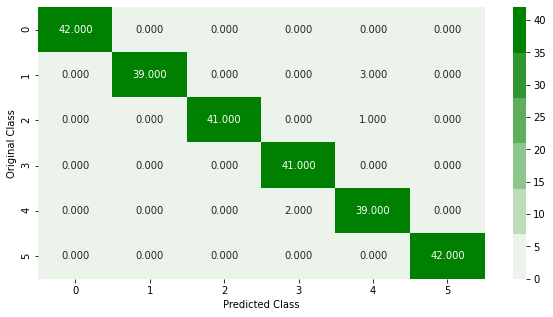

In [7]:
'''
FOR TRAINING DATA POINTS
'''
plot_confusion_matrix(Y_train, train_predicted_output)

Number of misclassified points  10.0 %
-------------------------------------------------- Confusion matrix --------------------------------------------------


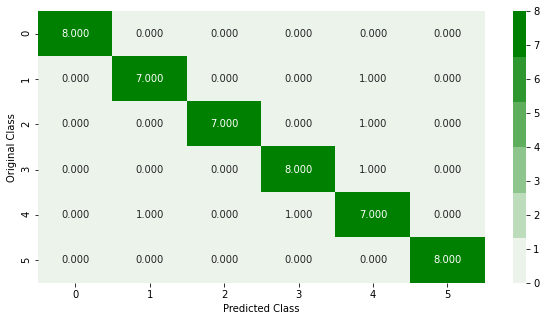

In [8]:
'''
FOR TESTING DATA POINTS
'''
plot_confusion_matrix(Y_test, test_predicted_output)

In [9]:
# to take the training and testing predicted datapoints and join it with the existing dataframes

final_training_df_new = final_training_df
final_testing_df_new = final_testing_df

final_training_df_new['SVM_MBO_output'] = train_predicted_output
final_testing_df_new['SVM_MBO_output'] = test_predicted_output

del final_training_df_new['condition']
del final_testing_df_new['condition']

print(final_training_df_new.shape, type(final_training_df_new))
print(final_testing_df_new.shape, type(final_testing_df_new))

(250, 11) <class 'pandas.core.frame.DataFrame'>
(50, 11) <class 'pandas.core.frame.DataFrame'>


In [10]:
final_training_df_new.head()

,Mean,SD,Kurtosis,sum,Skewness,max,min,range,RMS,Shape factor,SVM_MBO_output
0,-1.166491,-0.641888,-0.631950,-1.166651,0.326382,-0.407618,1.058829,-0.740012,0.033720,-0.413015,5
1,0.389329,0.830822,1.604929,0.389247,0.082017,1.090784,-1.204128,1.196487,0.744678,-0.432032,3
2,1.439655,-0.488640,0.576646,1.439758,1.949726,0.773832,0.418404,0.236606,0.108506,-0.619835,1
3,-0.641116,-0.718663,-0.972769,-0.641185,-0.538460,-1.190899,0.873037,-1.093864,-0.003179,-0.486737,5
4,0.658361,-0.764562,-0.388668,0.658378,-0.370158,-0.387232,-0.437583,-0.008617,-0.024884,-0.598013,1


In [11]:
X_train_new = final_training_df_new.drop('SVM_MBO_output', axis = 1)
X_test_new = final_testing_df_new.drop('SVM_MBO_output', axis = 1)

Y_train_new = final_training_df['SVM_MBO_output']
Y_test_new = final_testing_df['SVM_MBO_output']

print(X_train_new.shape, Y_train_new.shape)
print(X_test_new.shape, Y_test_new.shape)

(250, 10) (250,)
(50, 10) (50,)


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

MBO_DT_clf = DecisionTreeClassifier(max_depth=6, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto')

MBO_DT_clf.fit(X_train_new, Y_train_new)

print("The Decision Tree classifier has been trained....")

DT_train_predicted = MBO_DT_clf.predict(X_train_new)
DT_test_predicted = MBO_DT_clf.predict(X_test_new)

training_accuracy_DT = accuracy_score(Y_train_new, DT_train_predicted)
testing_accuracy_DT = accuracy_score(Y_test_new, DT_test_predicted)

print("TRAINING ACCURACY IS:- ", training_accuracy_DT)
print("TESTING ACCURACY IS:- ", testing_accuracy_DT)

The Decision Tree classifier has been trained....
TRAINING ACCURACY IS:-  0.988
TESTING ACCURACY IS:-  0.92


In [20]:
# to save this model having this particular accuracy

file_path_to_save_model = r'/content/drive/MyDrive/Research Paper/DATA/SVM_MBO_DT_clf.joblib'

joblib.dump(MBO_DT_clf, file_path_to_save_model)

print("The Model has been stored...")

The Model has been stored...


In [14]:
# to load the stored classifier
MBO_DT_clf = joblib.load(r'/content/drive/MyDrive/Research Paper/DATA/SVM_MBO_DT_clf.joblib')

print(type(MBO_DT_clf))
print("The Model has been loaded....")

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
The Model has been loaded....


In [15]:
X_train_new.columns

Index(['Mean ', 'SD', 'Kurtosis', 'sum', 'Skewness ', 'max', 'min', 'range',
       'RMS', 'Shape factor'],
      dtype='object')

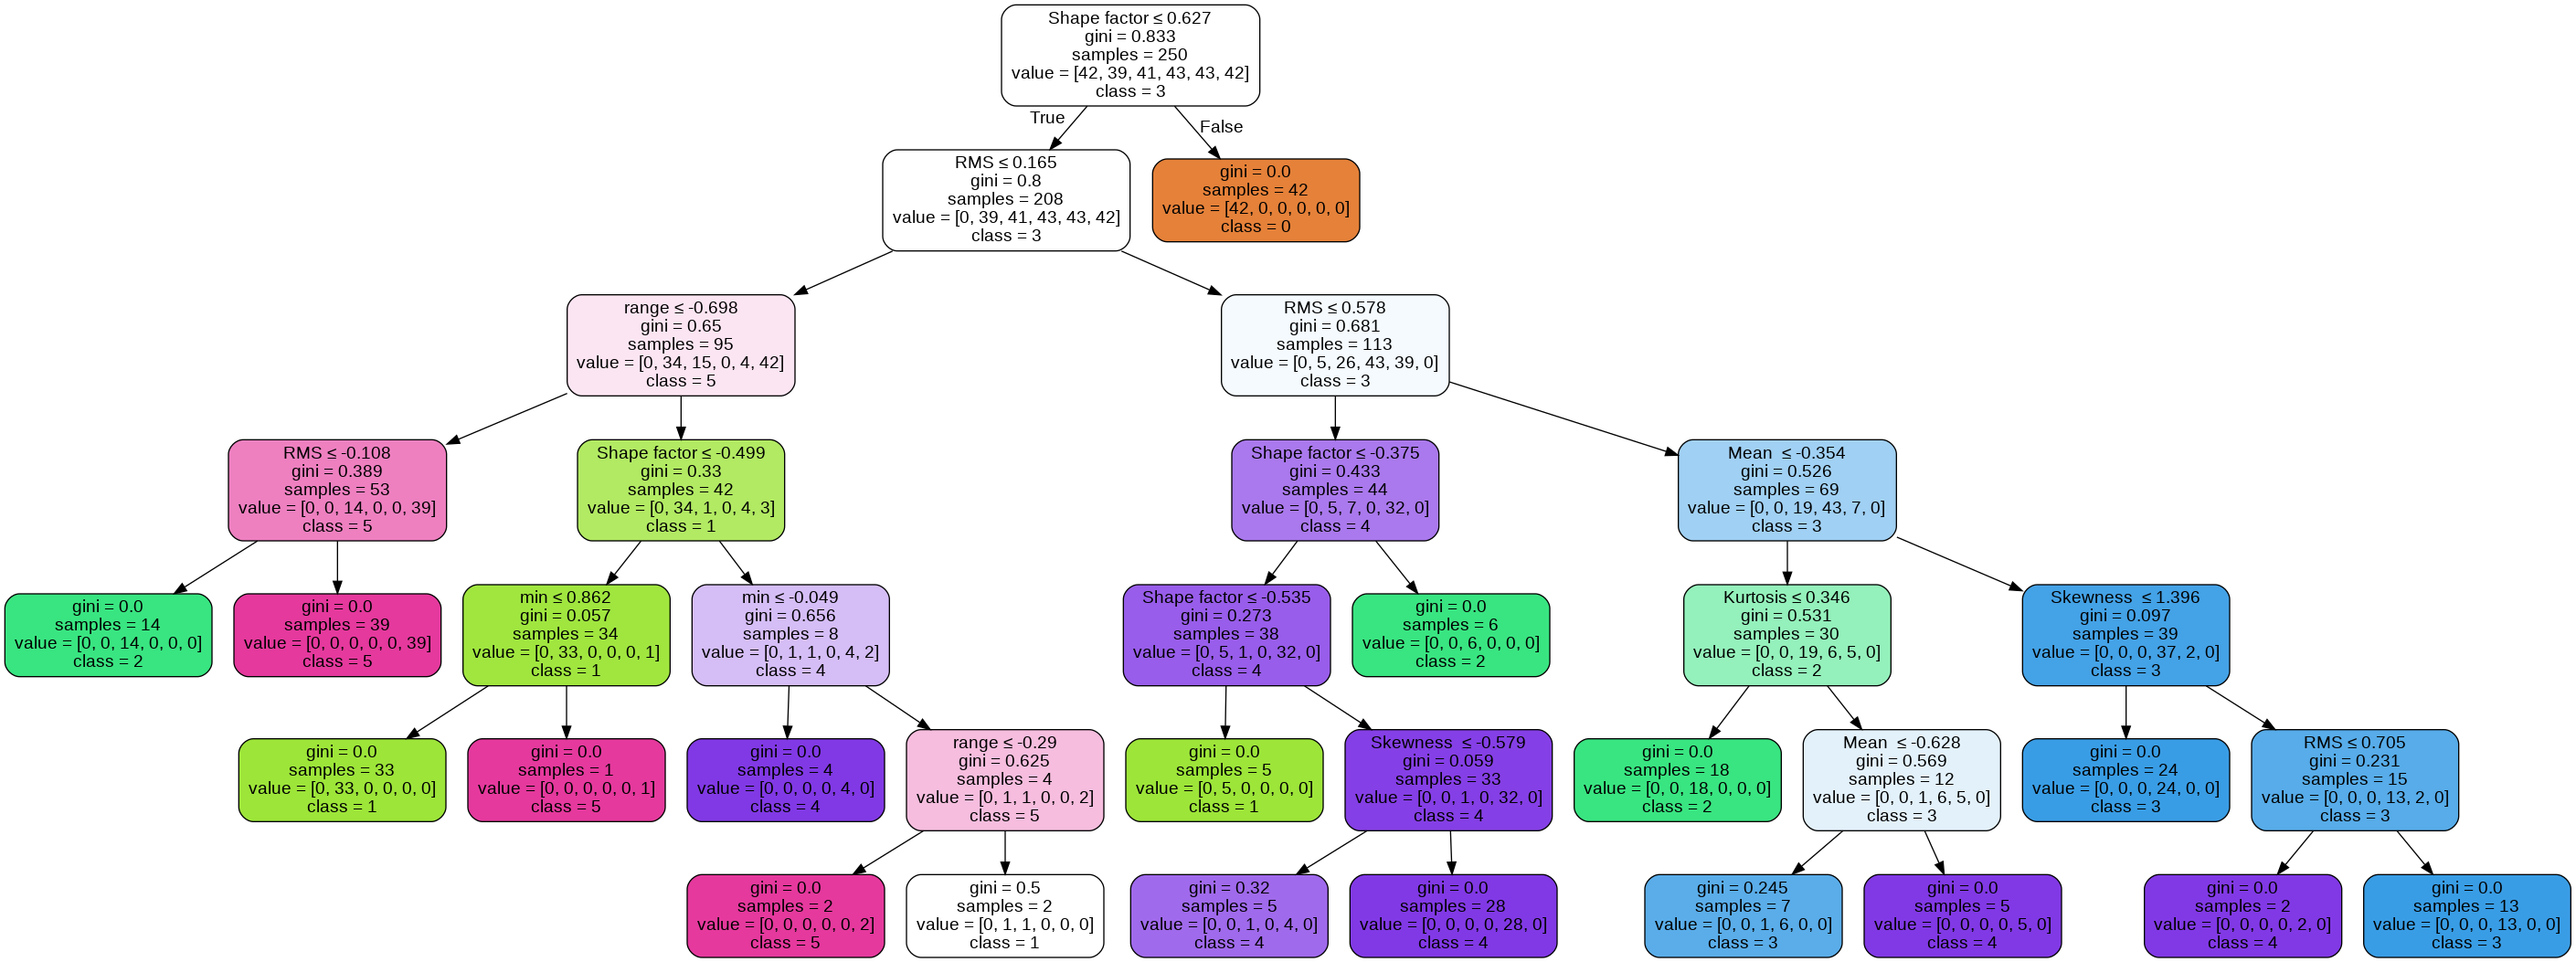

In [16]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

feature_columns = ['Mean ', 'SD', 'Kurtosis', 'sum', 'Skewness ', 'max', 'min', 'range', 'RMS', 'Shape factor']

dot_data = StringIO()
export_graphviz(MBO_DT_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_columns ,class_names=['0','1', '2', '3', '4', '5'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('heart_svm.png')
Image(graph.create_png())

In [17]:
import eli5

from eli5.sklearn import PermutationImportance

perm = PermutationImportance(MBO_DT_clf, random_state=1).fit(X_test_new, Y_test_new)
eli5.show_weights(perm, feature_names = feature_columns)

Weight,Feature
0.3280 ± 0.1509,RMS
0.2920 ± 0.0933,Shape factor
0.1400 ± 0.0912,range
0.0840 ± 0.0816,Mean
0.0760 ± 0.0299,Kurtosis
0.0600 ± 0.0358,min
0.0360 ± 0.0160,Skewness
0 ± 0.0000,max
0 ± 0.0000,sum
0 ± 0.0000,SD


In [27]:
eli5.explain_weights(MBO_DT_clf, feature_names = feature_columns)

Weight,Feature
0.3598,RMS
0.3222,Shape factor
0.1410,range
0.1061,Mean
0.0446,Kurtosis
0.0230,min
0.0033,Skewness
0,max
0,sum
0,SD


In [21]:
# correctly classified data point
eli5.explain_prediction(MBO_DT_clf, doc = X_test_new.iloc[0], show_feature_values = True)

TypeError: ignored

In [19]:
# incorrectly classified datapoint
eli5.show_prediction(MBO_DT_clf, X_test_new.iloc[12], show_feature_values = True, feature_names = feature_columns)

In [ ]:
# to create a for loop to classify each testting data point and extract data points which are misclassified

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def extracting_mis_classified_data_points(X_train, X_test, Y_train, Y_test):

  # a list to store the index number of misclassified test points
  misclassified_test_points = []

  # to store the original class of the misclassified datapoint
  original_class_test = []

  # to store the predicted class of the mislassified datapoint
  predicted_class_test = []
  
  X_train = X_train.reset_index(drop = True)
  X_test = X_test.reset_index(drop = True)


  # first to train the SVC which has the optimized parameters
  model = SVC(C = 3.5599737, gamma = 0.156438542, kernel = 'rbf', verbose = 1)

  model.fit(X_train, Y_train)


  # now to take the trained model and pass the test data points one by one and extract the mis-classified datapoints
  for i in range(len(X_test)):

    current_datapoint = X_test.iloc[i]
    current_datapoint = np.array(current_datapoint)
    current_datapoint = current_datapoint.reshape(1,-1)

    # to predict the class label for the current datapoint
    predicted_datapoint = model.predict(current_datapoint)


    # here the testing datapoint has been correctly classified
    if predicted_datapoint[0] == Y_test[i]:
      continue;

    # here the testing datapoint has been miscorrectly classified
    else:
      misclassified_test_points.append(i)
      original_class_test.append(Y_test[i])
      predicted_class_test.append(predicted_datapoint[0])


  return misclassified_test_points, original_class_test, predicted_class_test

In [ ]:
misclassified_test_points_index_values, original_class_test, predicted_class_test = extracting_mis_classified_data_points(X_train, X_test, Y_train, Y_test)

print(misclassified_test_points_index_values)
print("ORIGINAL CLASSES:- ", original_class_test)
print("PREDICTED CLASSES:- ", predicted_class_test)

[LibSVM][12, 20, 31, 32, 49]
ORIGINAL CLASSES:-  [1, 3, 4, 2, 4]
PREDICTED CLASSES:-  [4, 4, 3, 4, 1]


In [ ]:
# now to make use of these above extracted index values and fetch the misclassified points

misclassified_test_points = []

for index_value in misclassified_test_points_index_values:

  datapoint = X_test.iloc[index_value]

  misclassified_test_points.append(datapoint)

print(len(misclassified_test_points))

5


In [ ]:
print(misclassified_test_points[0])

Mean           -0.778170
SD             -0.566549
Kurtosis        0.474214
sum            -0.778002
Skewness        0.519317
max             0.398931
min            -0.627793
range           0.527744
RMS             0.070173
Shape factor   -0.453662
Name: 12, dtype: float64


In [ ]:
# to load the original data frames and to plot the graphs for each feature to know more about it

original_training_data = pd.read_csv(r'/content/drive/MyDrive/Research Paper/DATA/original_training_data.csv')

original_testing_data = pd.read_csv(r'/content/drive/MyDrive/Research Paper/DATA/original_testing_data.csv')

print(original_training_data.shape, type(original_training_data))
print(original_testing_data.shape, type(original_testing_data))

(250, 10) <class 'pandas.core.frame.DataFrame'>
(50, 10) <class 'pandas.core.frame.DataFrame'>


In [ ]:
original_training_data = original_training_data.reset_index(drop = True)
original_testing_data = original_testing_data.reset_index(drop = True)

In [ ]:
original_training_data['condition'] = Y_train

original_testing_data['condition'] = Y_test


print(original_training_data.shape, type(original_training_data))
print(original_testing_data.shape, type(original_testing_data))

(250, 11) <class 'pandas.core.frame.DataFrame'>
(50, 11) <class 'pandas.core.frame.DataFrame'>


In [ ]:
original_training_data.head()

,Mean,SD,Kurtosis,sum,Skewness,max,min,range,RMS,Shape factor,condition
0,0.009181,0.416964,5.941319,110.167944,0.274380,3.844778,-2.121655,5.966434,0.417048,45.426782,5
1,0.012859,0.563631,18.972485,154.305820,0.211248,6.289679,-5.260687,11.550366,0.563754,43.841805,3
2,0.015342,0.432226,12.982116,184.106808,0.693773,5.772517,-3.010012,8.782530,0.432480,28.188849,1
3,0.010423,0.409318,3.955840,125.074418,0.050947,2.566720,-2.379374,4.946094,0.409434,39.282248,5
4,0.013495,0.404747,7.358580,161.940549,0.094428,3.878042,-4.197384,8.075426,0.404955,30.007649,1


**I am selecting [SD, shape-factor, min, range, RMS] features as these were of highest importance according to the Decision Tree classifier**

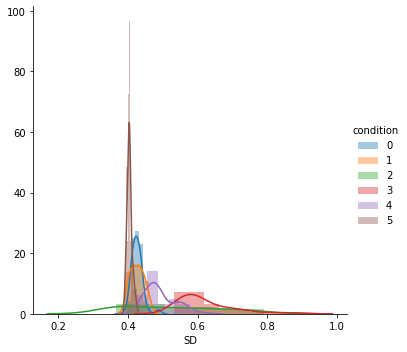

In [ ]:
# to plot histograms for SD

sns.FacetGrid(original_training_data, hue='condition', size=5) \
   .map(sns.distplot, "SD") \
   .add_legend();
plt.show();

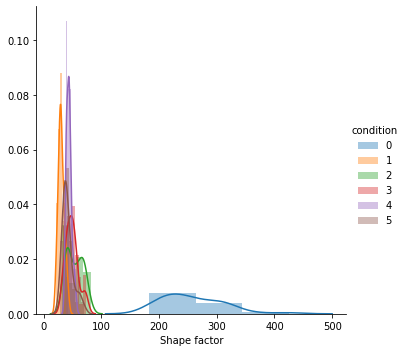

In [ ]:
# Histogram for Shape factor

sns.FacetGrid(original_training_data, hue='condition', size=5) \
   .map(sns.distplot, "Shape factor") \
   .add_legend();
plt.show();

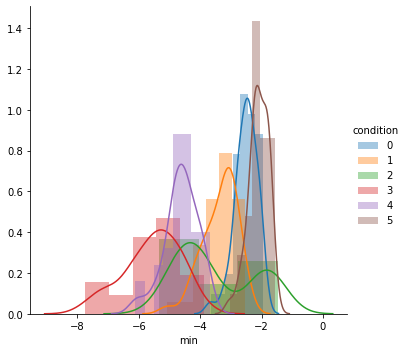

In [ ]:
# Histogram for min

sns.FacetGrid(original_training_data, hue='condition', size=5) \
   .map(sns.distplot, "min") \
   .add_legend();
plt.show();

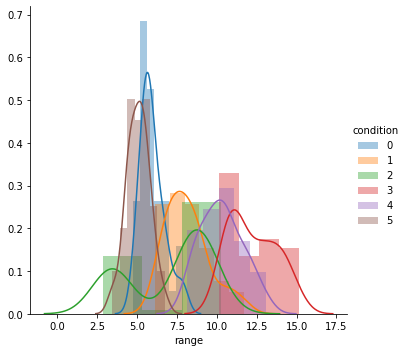

In [ ]:
# Histogram for range

sns.FacetGrid(original_training_data, hue='condition', size=5) \
   .map(sns.distplot, "range") \
   .add_legend();
plt.show();

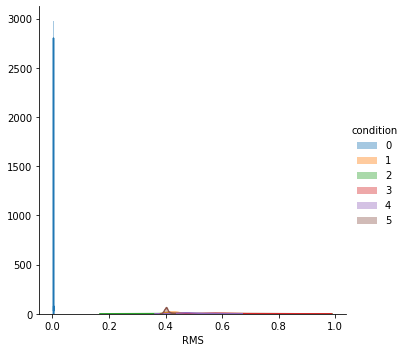

In [ ]:
# Histogram for RMS

sns.FacetGrid(original_training_data, hue='condition', size=5) \
   .map(sns.distplot, "RMS") \
   .add_legend();
plt.show();

**TO CREATE PAIR PLOTS**

In [ ]:
# to change the data type of the "condition" column from a numeric value to a string in order to plot the pairplots

# TRAINING
pairplot_condition_train = original_training_data['condition']
pairplot_condition_train = pairplot_condition_train.astype('string')

print(type(pairplot_condition_train[0]))

# TESTING
pairplot_condition_test = original_testing_data['condition']
pairplot_condition_test = pairplot_condition_test.astype('string')

print(type(pairplot_condition_test[0]))

# to add this column to the original data
original_training_data['string_condition'] = pairplot_condition_train
original_testing_data['string_condition'] = pairplot_condition_test

print(original_training_data.shape)
print()

<class 'str'>
(250, 12)


KeyError: ignored

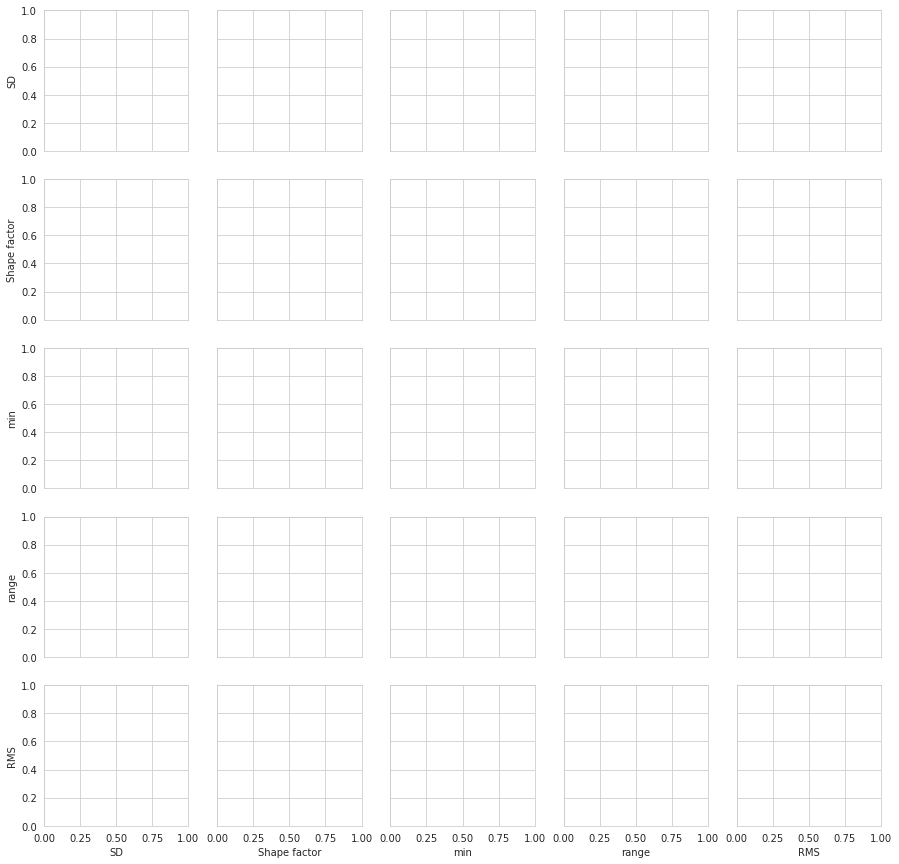

In [ ]:
sns.set_style("whitegrid");
sns.pairplot(original_training_data[['SD', 'Shape factor', 'min', 'range', 'RMS']], hue='string_condition', size=3);
plt.show()